In [1]:
# -- For Google Colab
#! pip install -q "gwpy=1.0.0" "gwosc=0.4.3"
%matplotlib inline

# Signal processing with GWpy part 2 - the time domain

Recall our 'raw' timeseries we loaded earlier:

Fetched 1 URLs from www.gw-osc.org for [1126259457 .. 1126259467))
Reading data... [Done]


/Users/jkanner/miniconda2/envs/ligo-py37/lib/python3.7/site-packages/gwpy/plot/plot.py:281: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super(Plot, self).show(warn=warn)


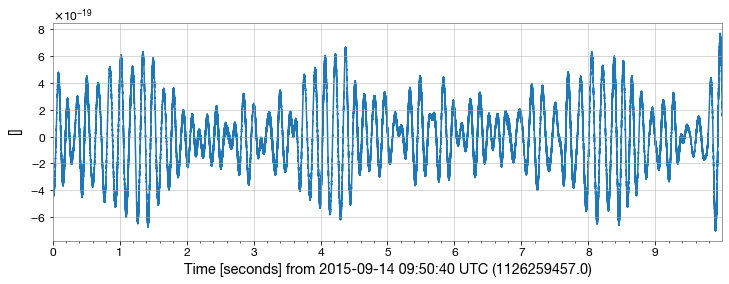

In [2]:
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries

gps = event_gps('GW150914')
segment = (int(gps) - 5, int(gps) + 5)
hdata = TimeSeries.fetch_open_data('H1', *segment, verbose=True, cache=True)
plot = hdata.plot()
plot.show()

Here we see what the unfiltered data look like; loud, low-frequency noises dominate the overall amplitude.

We also learned that we can study the frequency-domain content of that series using the Fourier transform:

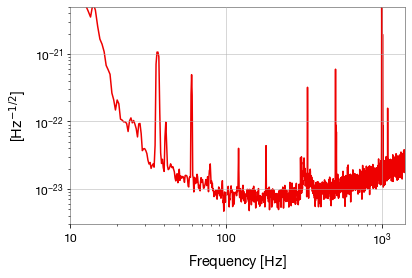

In [3]:
hasd = hdata.asd(fftlength=2)
plot2 = hasd.plot(color='gwpy:ligo-hanford')
ax = plot2.gca()
ax.set_xlim(10, 1400)
ax.set_ylim(3e-24, 5e-21)
plot2.show()

We can see that the data are dominated by noise in several ways:

- low frequency
- very high frequency
- spectral lines

Even if we zoom the timeseries to right around the (supposed?) event time, we can't see anything obvious:

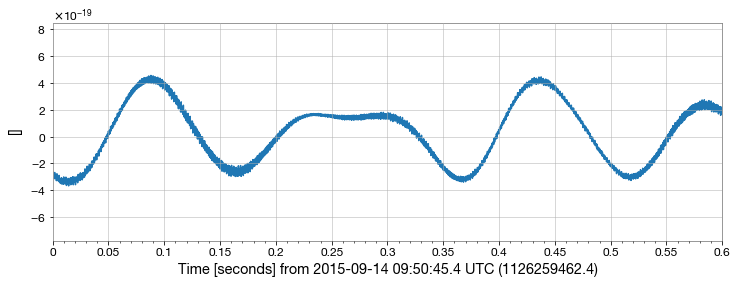

In [4]:
ax = plot.gca()
ax.set_epoch(gps)  # set T=0 on the X-axis
ax.set_xlim(gps, gps+.6)
plot

Ideally, we want to remove the noise from our timeseries, enter time-domain filtering.

We can filter these data to remove the noises at frequencies outside of our band of interest.
GW150914 came from a 'high-mass' binary black hole merger, which was resolvable in the LIGO detectors between ~50 Hz and ~250 Hz.
For other events, the frequencies of the bandpass might have to be tweaked depending on the signal morphology.

In [5]:
hbp = hdata.bandpass(50, 250, filtfilt=True)

<div class="alert alert-info">
We use `filtfilt=True` to perform the filter twice, once forward in time, and once backwards. This guarantees that any phase shifts introduced by the filter response will be cancelled out in the end.
</div>

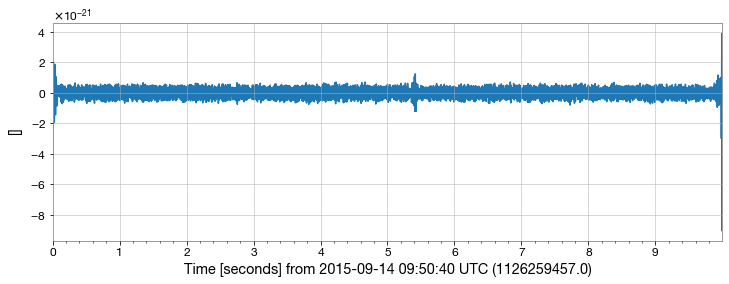

In [6]:
plot = hbp.plot()

This y-axis scaling looks a bit odd, because the amplitude at the beginning is much higher than the rest of the data; this is because it takes a fraction of a second for the filter to settle into a good state.

The best thing to do here is to throw away the first second, and the last second (remember we did the filtering twice!). We can do this using the [`.crop()`](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.crop) method, passing it the new start and end times in GPS format:

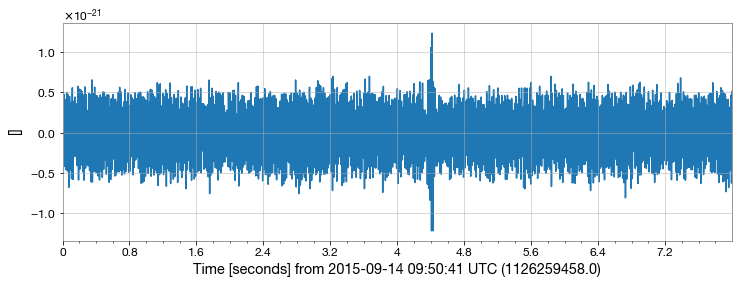

In [7]:
hbp = hbp.crop(int(gps) - 4, int(gps) + 4)
plot = hbp.plot()

Now we can clearly see a strong peak in our data, at around T=5.5 seconds! We can again zoom our plot to the time of interest:

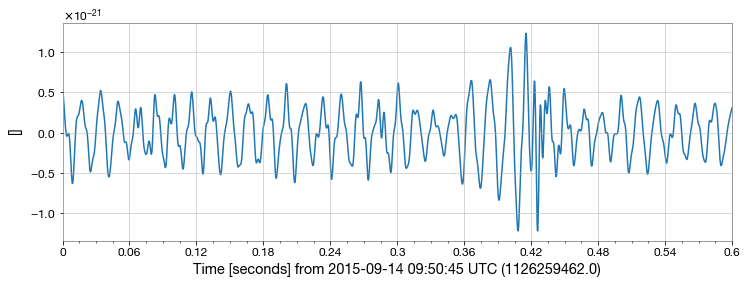

In [8]:
ax = plot.gca()
ax.set_epoch(int(gps))
ax.set_xlim(gps-.4, gps+.2)
plot

Does that look like a binary merger? Maybe.

The (possible) signal still looks a bit buried in the noise. More filtering!

From our ASD plot we the large spectral peaks in the data that are much louder than any potential gravitational-wave signal. We can design a special filter to excise power at those frequencies. Let's remove the fundamental, and the next two harmonics, of the 60 Hz US mains power supply.

<div class="alert alert-info">
There are _many_ more spectral lines present in the LIGO data, see [here](https://losc.ligo.org/o1speclines/) for more information on those. The 60 Hz power mains and harmonics are the loudest in the 50-250Hz band.
</div>

To do that we can use the [`gwpy.signal.filter_design`](https://gwpy.github.io/docs/stable/signal/#filter-design) module to design a series of [notches](https://gwpy.github.io/docs/stable/signal/#gwpy.signal.filter_design.notch):

In [9]:
from gwpy.signal import filter_design
notches = [filter_design.notch(f, hdata.sample_rate) for f in (60, 120, 180)]
powernotch = filter_design.concatenate_zpks(*notches)

Here we have used [`filter_design.contatenate_zpks`](https://gwpy.github.io/docs/stable/signal/index.html#gwpy.signal.filter_design.concatenate_zpks) to combine our three notch filters into a single filter that we can apply using [`TimeSeries.filter`](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.filter):

In [11]:
hclean = hbp.filter(powernotch, filtfilt=True)
plot = hclean.plot()
ax = plot.gca()
ax.set_epoch(int(gps))
ax.set_xlim(gps-.4, gps+.2)

IndexError: index 1 is out of bounds for axis 0 with size 1

We see a much cleaner signal now! To finish things off, lets make a plot that looks a little better: 

In [12]:
plot = hclean.plot(figsize=(12, 4), color='gwpy:ligo-hanford')
ax = plot.gca()
ax.set_xscale('seconds', epoch=int(gps))
ax.set_xlim(int(gps), int(gps)+.6)
ax.set_xlabel('Time (seconds) from 2015-09-14 09:50:45')
ax.set_ylim(-1e-21, 1e-21)
ax.set_ylabel('Strain amplitude')
ax.set_title('LIGO-Hanford strain data around GW150914')

NameError: name 'hclean' is not defined

Eureka! That looks like a nice, clean gravitational-wave signature, exactly what theory predicted to come from a binary black hole merger.

<div class="alert alert-warning">
This sort of time-domain filtering is _not_ used in an actual gravitational-wave search to claim detections, much more robust methods (the matched-filter) are used in those analyses (more on that tomorrow...).

## Challenge:

- clean up the `C00` data from H1 for GW170817 and make a plot like that above